# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [29]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [30]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [31]:
%load_ext autoreload
%autoreload 2
import c14
import c14.models.hepatocyte as hep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [38]:
data = pd.read_csv('../data/C14data_liver_samples_20200227.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology not in ["Y", "C"]')
edata = c14.exp_data(data)

In [39]:
data.head()

,type,sample,ploidy,pathology,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age,age
0,hepatocyte,HL#11,2n,T,1975.333333,2019.750000,0.01620,0.00640,77.0,44.416667,44.416667
1,hepatocyte,HL#11,4n,T,1975.333333,2019.750000,0.03960,0.00685,12.0,44.416667,44.416667
2,hepatocyte,HL#12,2n4n,T,1947.833333,2017.916667,0.02460,0.00660,59.0,70.083333,70.083333
3,hepatocyte,HL#14,2n4n,T,1943.000000,2018.000000,0.07402,0.01163,54.0,75.000000,75.000000
7,hepatocyte,HL#7,2n4n,T,1935.416667,2017.500000,0.03120,0.00765,30.0,82.083333,82.083333


## Fit the models

In [5]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'].copy(),data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'].copy(),data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [6]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [7]:
models = hep.models_list
# models = [c14.models.liver.R]
models

[c14.models.hepatocyte.R, c14.models.hepatocyte.Rq, c14.models.minimal.POP1]

In [8]:
np.average([1, 2], weights=[2, 2])

1.5

In [18]:
init_limit = {'r2': (-3, 0),  
              'r4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta4': (-3, 0),
              'f': (0, 1),
              'lambda_': (-3, 0),
             }

In [19]:
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [20]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

Fitting model R
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model Rq
[(-3, 0), (-3, 0), (0, 1), (-3, 0), (-3, 0)]
Fitting model POP1
[(-3, 0)]
CPU times: user 13.3 s, sys: 444 ms, total: 13.8 s
Wall time: 1min 8s


In [12]:
# %%time
# results = fit_models(edata, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [22]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[20, 50, 80],
                                     samples=1000,
                                    ignore_physics=True)
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [23]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

In [24]:
parameters[parameters['lower'] > parameters['point_estimate']]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


In [25]:
parameters[(parameters['upper'] < parameters['point_estimate'])]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


## Parameter Values

### Summarized

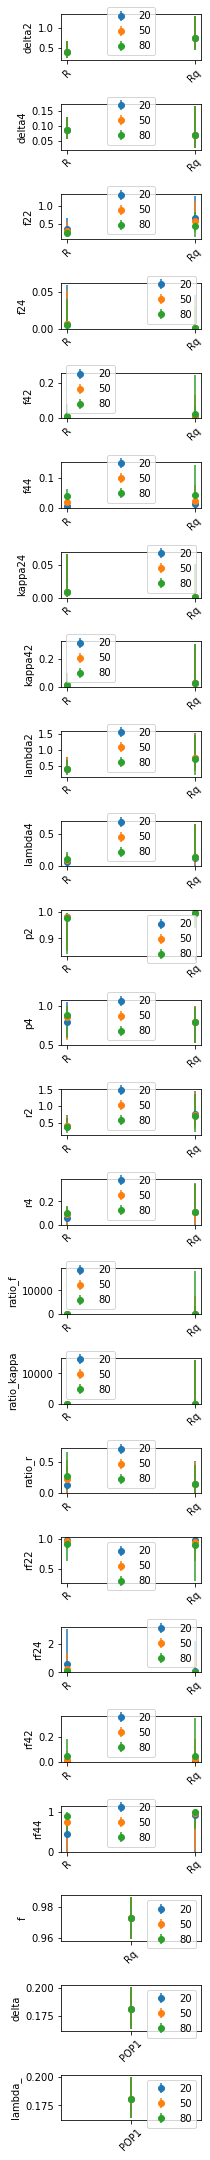

In [26]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]

fig, axs = plt.subplots(len(p_names), 1, figsize=(3, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, ax in zip(p_names, axs):
    data = parameters[parameters['parameter'] == parameter]
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
    ylim = ax.get_ylim()
    ax.set_ylim(max(ylim[0], 0), ylim[1])
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Detailed

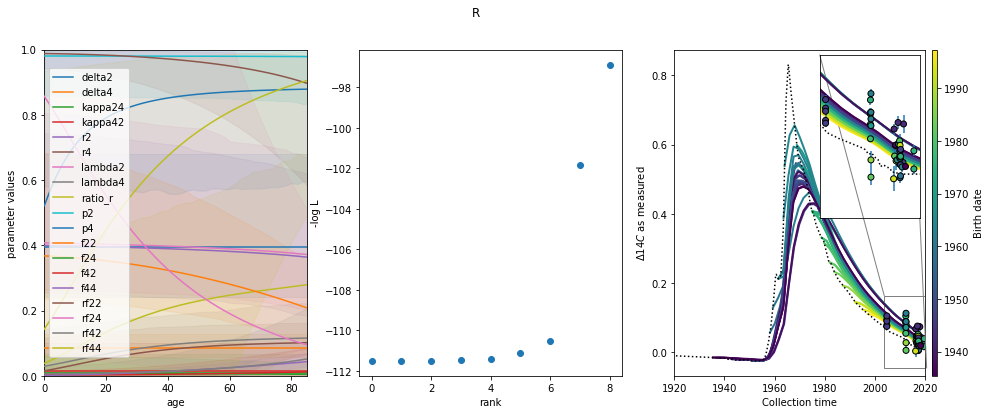

point_estimate        lower      upper
time parameter                                       
0    delta2          0.395366     0.241203   0.679938
     delta4         0.0857815     0.056836   0.127505
     f22             0.367731     0.234849   0.684319
     f24           0.00731022  0.000631625  0.0612889
     f42           0.00223907   0.00028713  0.0159505
...                       ...          ...        ...
100  ratio_r          0.30145    0.0457762   0.712059
     rf22             0.83375     0.387808   0.971001
     rf24           0.0589628   0.00458422   0.317168
     rf42           0.0831252    0.0144994   0.306096
     rf44            0.941037     0.682832   0.995416

[84 rows x 3 columns]

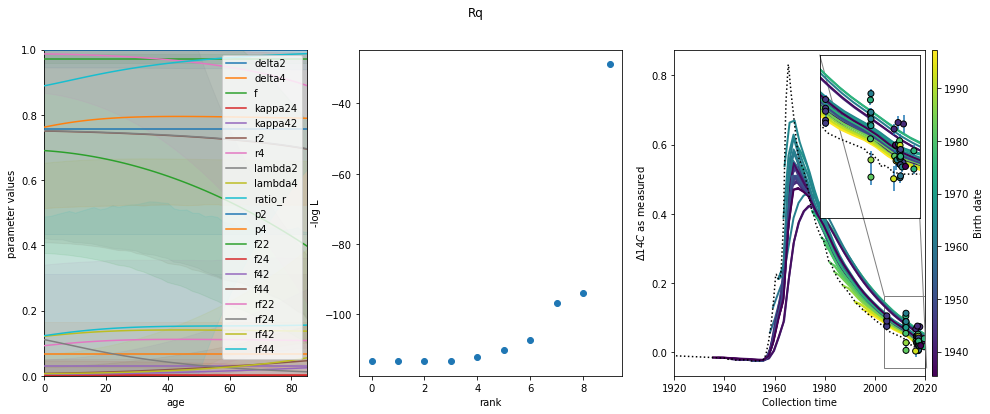

point_estimate        lower      upper
time parameter                                       
0    delta2          0.755733      0.43433    1.29669
     delta4         0.0682044    0.0273192   0.164761
     f               0.972626     0.959189   0.985951
     f22             0.690534     0.375161    1.34304
     f24          0.000920498  1.55612e-05  0.0472631
...                       ...          ...        ...
100  ratio_r         0.161128    -0.481647   0.452145
     rf22            0.824287   -0.0245463   0.983791
     rf24          0.00761788  4.21193e-05   0.228229
     rf42           0.0878566   0.00810442   0.512273
     rf44            0.992382     0.771771   0.999958

[88 rows x 3 columns]

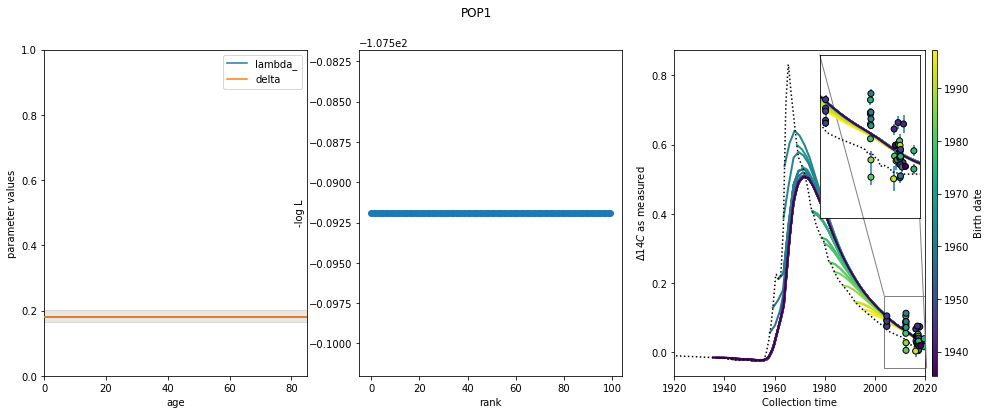

point_estimate     lower    upper
time parameter                                  
0    delta           0.181082  0.163722  0.20062
     lambda_         0.181082  0.163722  0.20062
50   delta           0.181082  0.163722  0.20062
     lambda_         0.181082  0.163722  0.20062
80   delta           0.181082  0.163722  0.20062
     lambda_         0.181082  0.163722  0.20062
100  delta           0.181082  0.163722  0.20062
     lambda_         0.181082  0.163722  0.20062

In [27]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa', 'ratio_f']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)
        axs[0].set_xlim(0, 85)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80, 100], ignore_physics=True
                                               ))
        except:
            pass

## Export

In [ ]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [ ]:
# _ = results.pop('POP1', None)

In [28]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
Rq,-212.219750,113.215138,6,0.000000,0.453684,1.000000
R,-211.471132,111.504797,5,0.748618,0.312027,1.453986
POP1,-210.898060,107.591887,2,1.321690,0.234289,1.936428


In [ ]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [ ]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [ ]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

In [ ]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()